## Hamiltonian MCMC baseline performance - 2D Gaussian

The purpose of this notebook is to propose baseline settings --- sampler hyperparameters and number of MCMC iterations --- for the Hamiltonian MCMC sampler on a 2D Gaussian distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy
import pints.plot

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=100),
    pints.GaussianLogPrior(mean=0, sd=100))

# Set up hyperparameters
initial_parameters = log_prior.sample(n=10)
n_chains = 10

method = pints.HamiltonianMCMC
is_run_parallel = True

In [2]:
# Make a small grid of HMC hyperparameters
leapfrog_steps = [5, 10, 20]
leapfrog_step_sizes = [0.02, 0.5, 2.0]

warmup = 200
n_iterations = 400

for step in leapfrog_steps:
    for size in leapfrog_step_sizes:
        # Set up problem
        sampler = pints.MCMCController(
            log_pdf=normal_log_pdf,
            x0=initial_parameters,
            chains=n_chains,
            method=method)
        sampler.set_max_iterations(n_iterations)
        sampler.set_parallel(is_run_parallel)
        sampler.set_log_to_screen(False)

        for s in sampler.samplers():
            s.set_leapfrog_step_size(size)
            s.set_leapfrog_steps(step)

        # Sample
        chains = sampler.run()
        
        print('Leapfrog: {}, step size: {}, time: {:.2f}s'.format(step, size, sampler.time()))
        print(pints.MCMCSummary(chains=chains[:, warmup:]))
        print('\n\n')

Leapfrog: 5, step size: 0.02, time: 6.50s
param    mean    std.    2.5%     25%      50%     75%     97.5%    rhat    ess
-------  ------  ------  -------  -------  ------  ------  -------  ------  -----
param 1  -2.34   85.40   -137.40  -55.72   -32.63  111.72  125.85   687.07  36.39
param 2  -5.29   105.24  -166.18  -112.08  3.93    65.61   164.19   667.11  35.19



Leapfrog: 5, step size: 0.5, time: 6.40s
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----
param 1  0.20    1.00    -2.05   -0.39  0.18   0.86   2.15     1.40    84.30
param 2  0.11    1.00    -1.67   -0.64  0.07   0.80   2.14     1.36    73.14



Leapfrog: 5, step size: 2.0, time: 6.72s
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------
param 1  -0.05   0.97    -1.87   -0.70  -0.04  0.63   1.83     1.01    417.15
param 2

These results suggest that strong performance can be achieved using 10 leapfrog steps with a step size of 2. While 20 leapfrog steps may be slightly better, it takes much longer to run.

Now we run a longer chain with these settings.

In [3]:
n_iterations = 10000
warmup = 1000

sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

for s in sampler.samplers():
    s.set_leapfrog_step_size(2.0)
    s.set_leapfrog_steps(10)

# Sample
chains = sampler.run()
print(pints.MCMCSummary(chains=chains[:, warmup:]))

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  --------
param 1  -0.00   1.00    -1.96   -0.68  -0.01  0.67   1.95     1.00    30000.00
param 2  0.00    1.00    -1.97   -0.67  0.00   0.68   1.96     1.00    30000.00


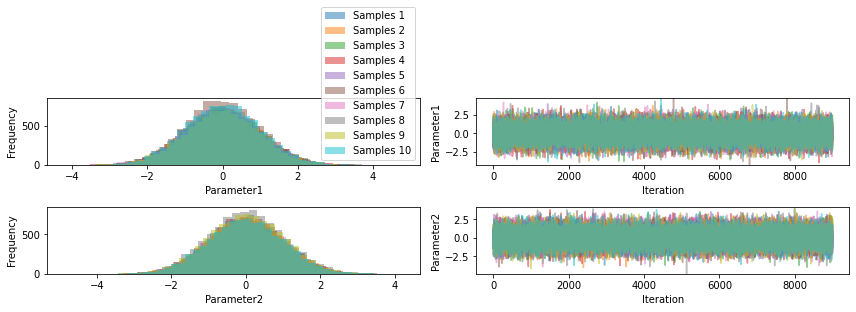

In [4]:
# Plot traces
fig = pints.plot.trace(chains[:,warmup:])
plt.show()

We can also plot the warmup phase.

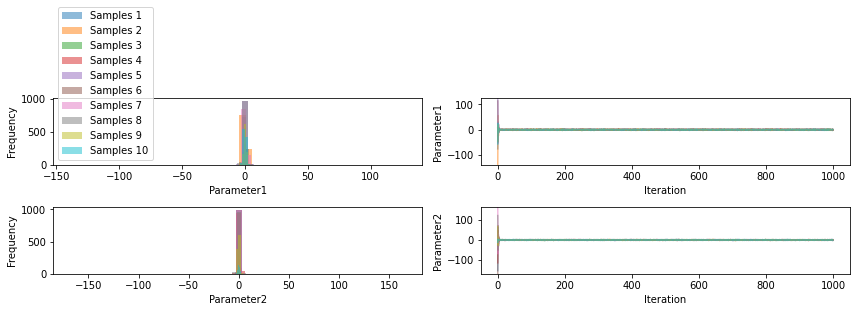

In [5]:
# Plot traces
fig = pints.plot.trace(chains[:,:warmup])
plt.show()

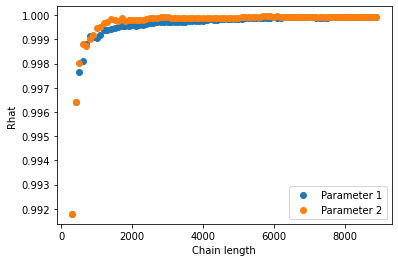

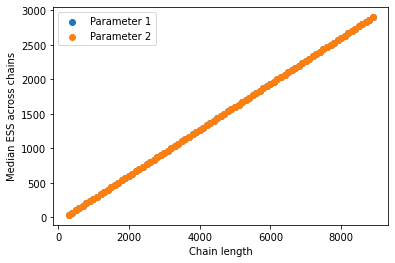

In [6]:
# Define chain lengths for Rhat evaluation
warmup = 200
chain_lengths = np.arange(start=300, stop=9000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=(n_lengths, n_parameters))
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = pints.rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.legend()
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

Convergence is near instant---the problem is extremely easy for HMC. The following baseline settings are suggested, which are more than sufficient to obtain a very accurate posterior when the sampler is working correctly.

Leapfrog steps: 10

Leapfrog step size: 2

Number of iterations: 2000 / 200 warmup

Number of chains: 3

## Convergence with multivariate Rhat

The analysis above uses the standard single variable Rhat from pints. We can repeat the study using a multivariate Rhat.

In [7]:
def _within(chains):
    # Get number of chains and number of parameters
    n_chains, _, n_parameters = chains.shape

    # Compute unbiased within-chain covariance estimate
    within_chain_cov = np.empty(shape=(n_chains, n_parameters, n_parameters))
    for chain_id, chain in enumerate(chains):
        within_chain_cov[chain_id] = np.cov(chain, ddof=1, rowvar=False)

    # Compute mean-within chain variance
    w = np.mean(within_chain_cov, axis=0)

    return w

def _between(chains):
    # Get number of samples
    n = chains.shape[1]

    # Compute within-chain mean
    within_chain_means = np.mean(chains, axis=1)

    # Compute covariance across chains of within-chain means
    between_chain_cov = np.cov(within_chain_means, ddof=1, rowvar=False)

    # Weight variance with number of samples per chain
    b = n * between_chain_cov

    return b

def multidimensional_rhat(chains):
    # Get number of samples
    n = chains.shape[1]

    # Split chains in half
    n = n // 2  # new length of chains
    if n < 1:
        raise ValueError(
            'Number of samples per chain after warm-up and chain splitting is '
            '%d. Method needs at least 1 sample per chain.' % n)
    chains = np.vstack([chains[:, :n], chains[:, -n:]])

    # Compute mean within-chain covariance
    w = _within(chains)

    # Compute mean between-chain convariance
    b = _between(chains)

    # Compute Rhat
    rhat = np.sqrt((n - 1.0) / n + np.linalg.det(b) / (np.linalg.det(w) * n))

    return rhat

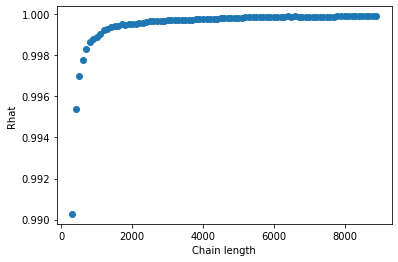

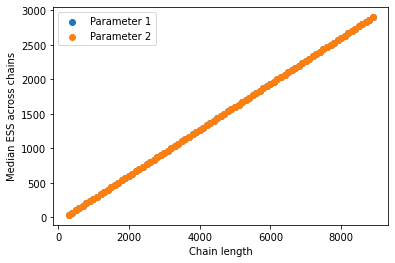

In [8]:
# Define chain lengths for Rhat evaluation
warmup = 200
chain_lengths = np.arange(start=300, stop=9000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=(n_lengths, n_parameters))
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = multidimensional_rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats[:, 0])
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

The results are similar to those obtained by the univariate method, owing to the ease of the problem. Thus, no change is recommended to the baseline hyperparameter settings recommended above.